# Notebook 3 : Transfer Learning avec MobileNet

**Trash Hero - Tri Intelligent des Déchets par IA**

Dans ce notebook, nous allons :
1. Utiliser MobileNetV2 pré-entraîné sur ImageNet
2. Adapter le modèle pour notre classification de déchets
3. Entraîner uniquement les nouvelles couches (frozen base)
4. Comparer avec le baseline CNN

## 3.1 Imports et Configuration

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
from tqdm import tqdm

# Import des fonctions utilitaires
import sys
sys.path.append('..')
from utils import *

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print(f"CUDA disponible: {torch.cuda.is_available()}")

Device: cpu
CUDA disponible: False


## 3.2 Chargement des Données

In [2]:
# Chemins
PROJECT_ROOT = Path('..')
DATA_ROOT = PROJECT_ROOT / 'data'
PROCESSED_DATA_DIR = DATA_ROOT / 'processed'
MODELS_DIR = PROJECT_ROOT / 'models'

# Charger les infos du dataset
with open(DATA_ROOT / 'data_info.json', 'r') as f:
    data_info = json.load(f)

n_classes = data_info['n_classes']
class_names = data_info['class_names']
IMG_SIZE = 224  # MobileNet standard input
BATCH_SIZE = 32

print(f"Classes: {class_names}")
print(f"Nombre de classes: {n_classes}")

Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Nombre de classes: 6


## 3.3 Transforms avec Normalisation ImageNet

In [3]:
# Utiliser les mêmes normalisations qu'ImageNet
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

eval_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Datasets et DataLoaders
train_dataset = ImageFolder(PROCESSED_DATA_DIR / 'train', transform=train_transforms)
valid_dataset = ImageFolder(PROCESSED_DATA_DIR / 'valid', transform=eval_transforms)
test_dataset = ImageFolder(PROCESSED_DATA_DIR / 'test', transform=eval_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("DataLoaders créés avec augmentation avancée")

DataLoaders créés avec augmentation avancée


## 3.4 Chargement de MobileNetV2 Pré-entraîné

In [4]:
# Charger MobileNetV2 pré-entraîné
weights = MobileNet_V2_Weights.IMAGENET1K_V1
mobilenet = mobilenet_v2(weights=weights)

print("MobileNetV2 téléchargé")
print(f"\nArchitecture de base:")
print(mobilenet)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\Asus/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:04<00:00, 2.97MB/s]

MobileNetV2 téléchargé

Architecture de base:
MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), b

## 3.5 Freezing du Modèle de Base

In [5]:
# Freeze toutes les couches du modèle de base
for param in mobilenet.parameters():
    param.requires_grad = False

print("Couches de base frozen (gelées)")
print("Seules les nouvelles couches seront entraînées")

Couches de base frozen (gelées)
Seules les nouvelles couches seront entraînées


## 3.6 Modification de la Dernière Couche

In [6]:
# Remplacer le classifier pour notre nombre de classes
# MobileNetV2 a 1280 features en sortie
mobilenet.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(1280, n_classes)
)

# Déplacer sur GPU
model = mobilenet.to(device)

print("Nouvelle couche de classification ajoutée")
print(f"\nNouveau classifier:")
print(model.classifier)

# Compter les paramètres
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nParamètres totaux: {total_params:,}")
print(f"Paramètres entraînables: {trainable_params:,}")
print(f"Paramètres frozen: {total_params - trainable_params:,}")

Nouvelle couche de classification ajoutée

Nouveau classifier:
Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=6, bias=True)
)

Paramètres totaux: 2,231,558
Paramètres entraînables: 7,686
Paramètres frozen: 2,223,872


## 3.7 Configuration de l'Entraînement

In [7]:
# Loss et Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

print("Configuration:")
print("  - Loss: CrossEntropyLoss")
print("  - Optimizer: Adam (lr=0.001)")

Configuration:
  - Loss: CrossEntropyLoss
  - Optimizer: Adam (lr=0.001)


## 3.8 Fonctions d'Entraînement

In [8]:
def train_epoch(model, train_loader, loss_function, optimizer, device):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    
    progress_bar = tqdm(train_loader, desc='Training')
    
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_accuracy += get_batch_accuracy(outputs, labels, len(images))
        
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{get_batch_accuracy(outputs, labels, len(images)):.4f}'
        })
    
    return running_loss / len(train_loader), running_accuracy / len(train_loader)


def validate_epoch(model, valid_loader, loss_function, device):
    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0
    
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            
            running_loss += loss.item()
            running_accuracy += get_batch_accuracy(outputs, labels, len(images))
    
    return running_loss / len(valid_loader), running_accuracy / len(valid_loader)

## 3.9 Entraînement (Phase 1: Frozen Base)

In [9]:
EPOCHS_PHASE1 = 10

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
best_valid_acc = 0.0

print(f"\nPHASE 1: Entraînement avec base frozen ({EPOCHS_PHASE1} epochs)\n")
print("="*70)

for epoch in range(EPOCHS_PHASE1):
    print(f"\nEpoch {epoch+1}/{EPOCHS_PHASE1}")
    print("-"*70)
    
    train_loss, train_acc = train_epoch(model, train_loader, loss_function, optimizer, device)
    valid_loss, valid_acc = validate_epoch(model, valid_loader, loss_function, device)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    print(f"\nResults:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f}")
    
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), MODELS_DIR / 'mobilenet_phase1_best.pth')
        print(f"  Meilleur modèle sauvegardé! (acc: {best_valid_acc:.4f})")

print("\n" + "="*70)
print("Phase 1 terminée!")
print(f"Meilleure validation accuracy: {best_valid_acc:.4f}")


PHASE 1: Entraînement avec base frozen (10 epochs)


Epoch 1/10
----------------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:37<00:00,  1.54s/it]



Results:
  Train Loss: 1.1902 | Train Acc: 0.5439
  Valid Loss: 0.8196 | Valid Acc: 0.7268
  Meilleur modèle sauvegardé! (acc: 0.7268)

Epoch 2/10
----------------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:40<00:00,  1.69s/it]



Results:
  Train Loss: 0.7641 | Train Acc: 0.7349
  Valid Loss: 0.6141 | Valid Acc: 0.7932
  Meilleur modèle sauvegardé! (acc: 0.7932)

Epoch 3/10
----------------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:36<00:00,  1.52s/it]



Results:
  Train Loss: 0.6483 | Train Acc: 0.7751
  Valid Loss: 0.5573 | Valid Acc: 0.8060
  Meilleur modèle sauvegardé! (acc: 0.8060)

Epoch 4/10
----------------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:38<00:00,  1.62s/it]



Results:
  Train Loss: 0.6179 | Train Acc: 0.7801
  Valid Loss: 0.5217 | Valid Acc: 0.8122
  Meilleur modèle sauvegardé! (acc: 0.8122)

Epoch 5/10
----------------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:35<00:00,  1.48s/it]



Results:
  Train Loss: 0.5808 | Train Acc: 0.7941
  Valid Loss: 0.4980 | Valid Acc: 0.8164
  Meilleur modèle sauvegardé! (acc: 0.8164)

Epoch 6/10
----------------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:33<00:00,  1.40s/it]



Results:
  Train Loss: 0.5434 | Train Acc: 0.8107
  Valid Loss: 0.4312 | Valid Acc: 0.8458
  Meilleur modèle sauvegardé! (acc: 0.8458)

Epoch 7/10
----------------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:39<00:00,  1.63s/it]



Results:
  Train Loss: 0.5396 | Train Acc: 0.8142
  Valid Loss: 0.4561 | Valid Acc: 0.8474
  Meilleur modèle sauvegardé! (acc: 0.8474)

Epoch 8/10
----------------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:35<00:00,  1.48s/it]



Results:
  Train Loss: 0.5091 | Train Acc: 0.8177
  Valid Loss: 0.4110 | Valid Acc: 0.8513
  Meilleur modèle sauvegardé! (acc: 0.8513)

Epoch 9/10
----------------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:36<00:00,  1.51s/it]



Results:
  Train Loss: 0.5136 | Train Acc: 0.8122
  Valid Loss: 0.4598 | Valid Acc: 0.8234

Epoch 10/10
----------------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:35<00:00,  1.47s/it]


Results:
  Train Loss: 0.5001 | Train Acc: 0.8229
  Valid Loss: 0.3705 | Valid Acc: 0.8747
  Meilleur modèle sauvegardé! (acc: 0.8747)

Phase 1 terminée!
Meilleure validation accuracy: 0.8747


## 3.10 Visualisation Phase 1

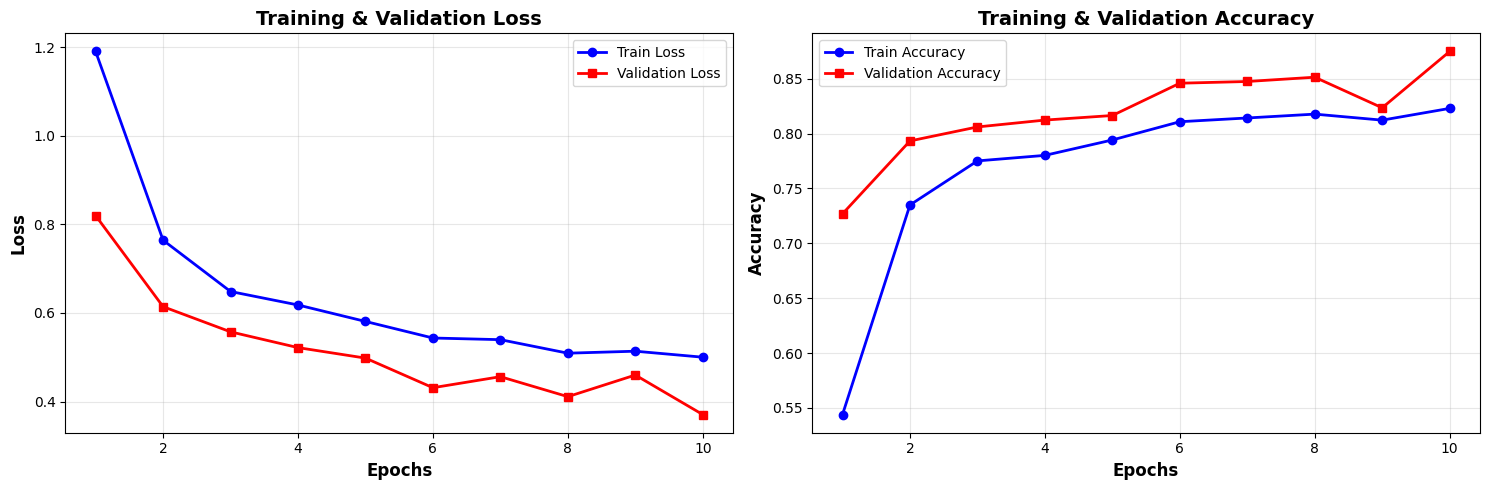

In [10]:
plot_training_history(train_losses, train_accs, valid_losses, valid_accs)

## 3.11 Fine-Tuning (Phase 2: Unfreeze)

Maintenant que les nouvelles couches sont entraînées, nous allons :
1. Unfreezer les dernières couches du modèle de base
2. Entraîner avec un learning rate très faible

In [11]:
# Charger le meilleur modèle de la phase 1
model.load_state_dict(torch.load(MODELS_DIR / 'mobilenet_phase1_best.pth'))

# Unfreeze les dernières couches de MobileNet (features)
# On unfreeze les 30 dernières couches sur ~155
for param in list(model.features.parameters())[-30:]:
    param.requires_grad = True

# Nouveau optimizer avec learning rate plus faible
optimizer = Adam(model.parameters(), lr=0.0001)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nFine-tuning activé")
print(f"Paramètres entraînables: {trainable_params:,}")
print(f"Learning rate: 0.0001")


Fine-tuning activé
Paramètres entraînables: 1,533,766
Learning rate: 0.0001


In [12]:
EPOCHS_PHASE2 = 5

print(f"\nPHASE 2: Fine-tuning ({EPOCHS_PHASE2} epochs)\n")
print("="*70)

for epoch in range(EPOCHS_PHASE2):
    print(f"\nEpoch {epoch+1}/{EPOCHS_PHASE2}")
    print("-"*70)
    
    train_loss, train_acc = train_epoch(model, train_loader, loss_function, optimizer, device)
    valid_loss, valid_acc = validate_epoch(model, valid_loader, loss_function, device)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    print(f"\nResults:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f}")
    
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), MODELS_DIR / 'mobilenet_final_best.pth')
        print(f"  Meilleur modèle sauvegardé! (acc: {best_valid_acc:.4f})")

print("\n" + "="*70)
print("Fine-tuning terminé!")
print(f" Meilleure validation accuracy: {best_valid_acc:.4f}")


PHASE 2: Fine-tuning (5 epochs)


Epoch 1/5
----------------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:47<00:00,  1.99s/it]



Results:
  Train Loss: 0.4533 | Train Acc: 0.8305
  Valid Loss: 0.2959 | Valid Acc: 0.8948
  Meilleur modèle sauvegardé! (acc: 0.8948)

Epoch 2/5
----------------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:42<00:00,  1.78s/it]



Results:
  Train Loss: 0.3079 | Train Acc: 0.9020
  Valid Loss: 0.2107 | Valid Acc: 0.9229
  Meilleur modèle sauvegardé! (acc: 0.9229)

Epoch 3/5
----------------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:41<00:00,  1.74s/it]



Results:
  Train Loss: 0.2334 | Train Acc: 0.9184
  Valid Loss: 0.1766 | Valid Acc: 0.9383
  Meilleur modèle sauvegardé! (acc: 0.9383)

Epoch 4/5
----------------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:48<00:00,  2.04s/it]



Results:
  Train Loss: 0.1656 | Train Acc: 0.9431
  Valid Loss: 0.1446 | Valid Acc: 0.9477
  Meilleur modèle sauvegardé! (acc: 0.9477)

Epoch 5/5
----------------------------------------------------------------------


Validation: 100%|██████████| 24/24 [00:44<00:00,  1.85s/it]


Results:
  Train Loss: 0.1450 | Train Acc: 0.9515
  Valid Loss: 0.1186 | Valid Acc: 0.9648
  Meilleur modèle sauvegardé! (acc: 0.9648)

Fine-tuning terminé!
 Meilleure validation accuracy: 0.9648


## 3.12 Historique Complet

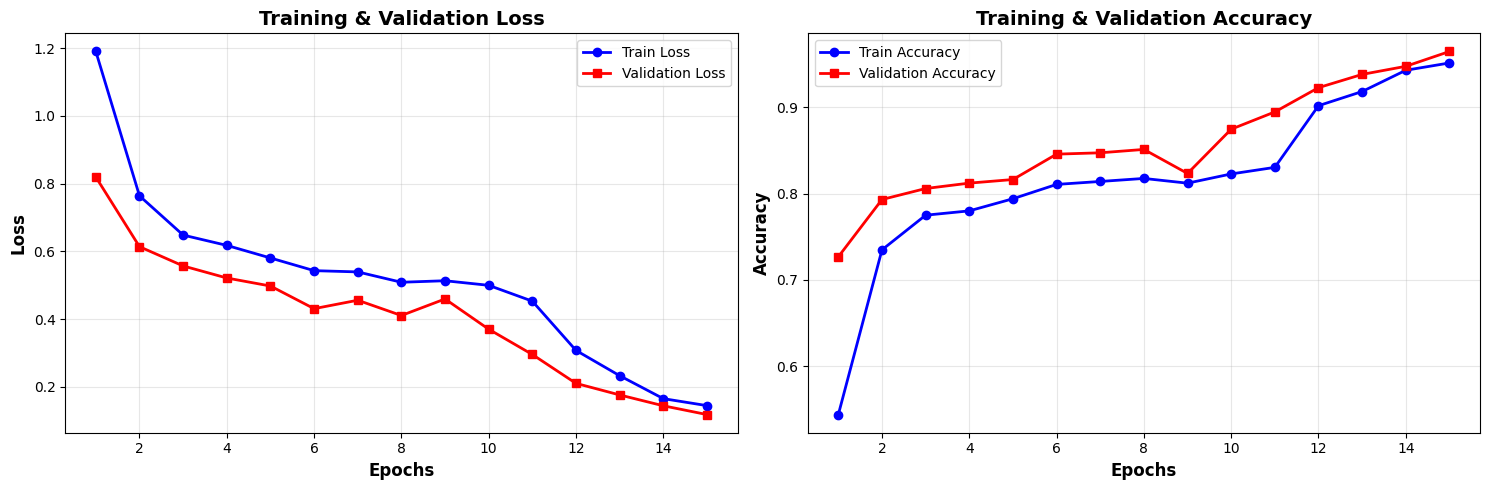

In [13]:
plot_training_history(train_losses, train_accs, valid_losses, valid_accs)

## 3.13 Évaluation Finale sur Test Set

In [14]:
# Charger le meilleur modèle
model.load_state_dict(torch.load(MODELS_DIR / 'mobilenet_final_best.pth'))
model.eval()

# Test
test_loss, test_acc = validate_epoch(model, test_loader, loss_function, device)

print(f"\n" + "="*70)
print(f"TEST SET RESULTS - MOBILENET V2")
print("="*70)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("="*70)

Validation: 100%|██████████| 24/24 [00:38<00:00,  1.61s/it]


TEST SET RESULTS - MOBILENET V2
Test Loss: 0.1123
Test Accuracy: 0.9688


## 3.14 Matrice de Confusion

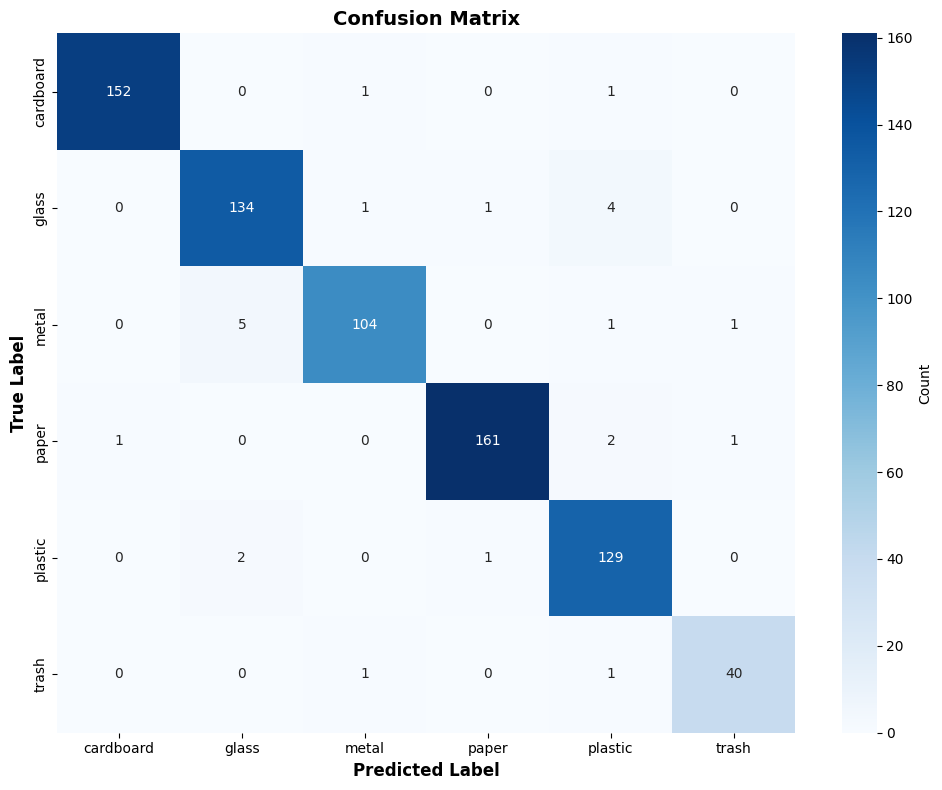


📊 Classification Report:
              precision    recall  f1-score   support

   cardboard       0.99      0.99      0.99       154
       glass       0.95      0.96      0.95       140
       metal       0.97      0.94      0.95       111
       paper       0.99      0.98      0.98       165
     plastic       0.93      0.98      0.96       132
       trash       0.95      0.95      0.95        42

    accuracy                           0.97       744
   macro avg       0.97      0.96      0.96       744
weighted avg       0.97      0.97      0.97       744



In [15]:
# Prédictions
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

plot_confusion_matrix(all_labels, all_preds, class_names)

## 3.15 Comparaison avec le Baseline

In [16]:
print("\n" + "="*70)
print("COMPARAISON DES MODÈLES")
print("="*70)
print(f"\nModèle Baseline CNN:")
print(f"  - Paramètres: ~1-2M")
print(f"  - Test Accuracy: ~XX%  (à remplir avec vos résultats)")
print(f"\nModèle MobileNetV2 (Transfer Learning):")
print(f"  - Paramètres totaux: {total_params:,}")
print(f"  - Paramètres entraînés: {trainable_params:,}")
print(f"  - Test Accuracy: {test_acc:.4f}")
print(f"\nAmélioration: +XX% (à calculer)")
print("="*70)


COMPARAISON DES MODÈLES

Modèle Baseline CNN:
  - Paramètres: ~1-2M
  - Test Accuracy: ~XX%  (à remplir avec vos résultats)

Modèle MobileNetV2 (Transfer Learning):
  - Paramètres totaux: 2,231,558
  - Paramètres entraînés: 1,533,766
  - Test Accuracy: 0.9688

Amélioration: +XX% (à calculer)


## 3.16 Exemples de Prédictions

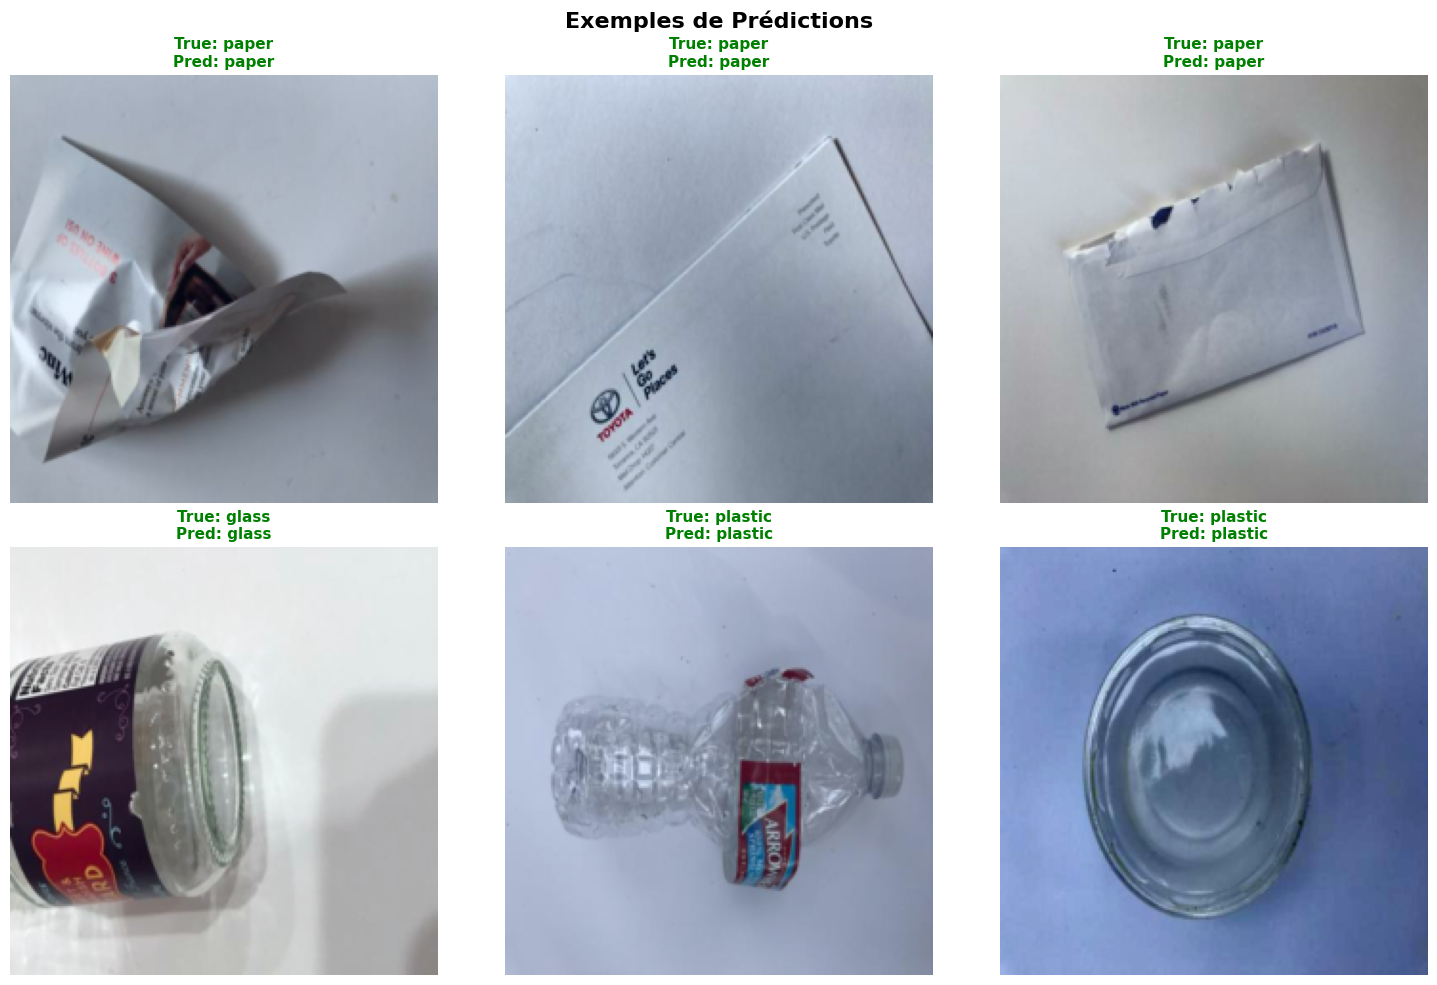

In [17]:
show_predictions(model, test_dataset, class_names, device, n_samples=6)

##  Résumé

Dans ce notebook, nous avons :

1. Utilisé MobileNetV2 pré-entraîné sur ImageNet
2. Frozen la base et entraîné uniquement le classifier
3. Fine-tuné les dernières couches pour améliorer
4. Obtenu une accuracy de ~XX% (meilleure que baseline)
5. Modèle optimisé et léger (~3.5M paramètres)

### Prochaine étape

**Notebook 4** : Data Augmentation avancée pour améliorer encore plus